In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from upsetplot import from_contents, plot

In [2]:
info_job_level_dfs = {}
info_job_level_dfs["gpu_utilization"] = pd.read_csv("job_level_gpu_utilization.csv")
info_job_level_dfs["tensor_active"] = pd.read_csv("job_level_tensor_active.csv")
info_job_level_dfs["fp64_active"] = pd.read_csv("job_level_fp64_active.csv")
info_job_level_dfs["fp32_active"] = pd.read_csv("job_level_fp32_active.csv")
info_job_level_dfs["fp16_active"] = pd.read_csv("job_level_fp16_active.csv")

gputil_all = info_job_level_dfs["gpu_utilization"]

In [3]:
upset_data = from_contents(
    {
        "tensor_active": set(info_job_level_dfs["tensor_active"][info_job_level_dfs["tensor_active"]['jobid'].isin(list(gputil_all["jobid"]))]["jobid"]),
        "fp64_active":  set(info_job_level_dfs["fp64_active"][info_job_level_dfs["fp64_active"]['jobid'].isin(list(gputil_all["jobid"]))]["jobid"]),
        "fp32_active":  set(info_job_level_dfs["fp32_active"][info_job_level_dfs["fp32_active"]['jobid'].isin(list(gputil_all["jobid"]))]["jobid"]),
        "fp16_active":  set(info_job_level_dfs["fp16_active"][info_job_level_dfs["fp16_active"]['jobid'].isin(list(gputil_all["jobid"]))]["jobid"]),
    }
)

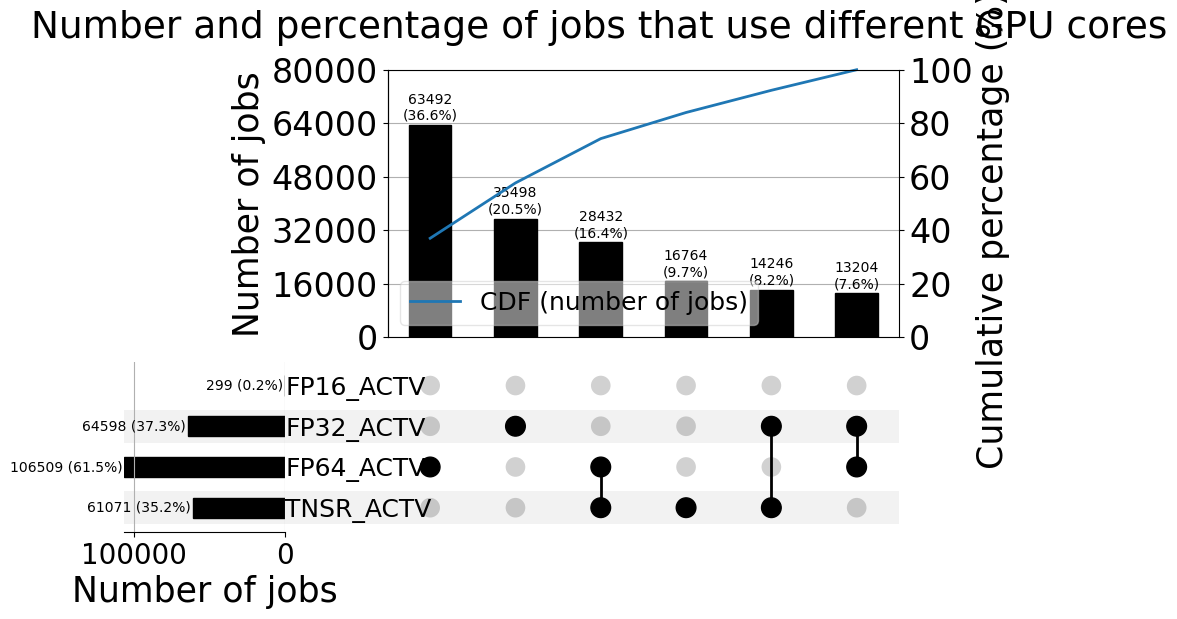

In [4]:
upset_data_reset = upset_data.reset_index().dropna()

upset_data_reset = upset_data_reset.rename(columns={
    "tensor_active": "TNSR_ACTV", 
    "fp64_active": "FP64_ACTV", 
    "fp32_active": "FP32_ACTV", 
    "fp16_active": "FP16_ACTV"
})

intersection_counts = upset_data_reset.groupby(
    ['TNSR_ACTV', 'FP64_ACTV', 'FP32_ACTV', 'FP16_ACTV']
).size()


intersection_counts = intersection_counts.reset_index(name="count")

bar_counts = intersection_counts["count"]

cumulative_counts_bars = bar_counts.sort_values(ascending=False)[:6].cumsum()
total_counts_bars = cumulative_counts_bars.iloc[-1] 
cdf_bars = (cumulative_counts_bars / total_counts_bars) * 100

fig = plt.figure(figsize=(10, 6))
plot_result = plot(
    upset_data_reset.set_index(['TNSR_ACTV', 'FP64_ACTV', 'FP32_ACTV', 'FP16_ACTV']), 
    sort_by="cardinality",
    fig=fig,
    element_size=None,
    show_counts="%d",
    show_percentages=True,
    sort_categories_by=None,
    # facecolor=colors[2],
    min_subset_size=10000
)

ax1 = plot_result["intersections"]

ax1.set_yticks([0, 16000, 32000, 48000, 64000, 80000])  

ax2 = ax1.twinx() 
ax2.plot(
    range(len(cdf_bars)),
    cdf_bars,
    # color=colors[0], 
    # marker=markers[2], 
    label='CDF (number of jobs)', 
    linewidth=2,
    clip_on=False
)
ax2.set_ylim(0, 100)
ax2.set_ylabel("Cumulative percentage (%)", fontsize=25)
ax2.set_yticks([0, 20, 40, 60, 80, 100]) 
ax2.tick_params(labelsize=24)
ax2.yaxis.set_label_coords(1.15, 0.4)
# Customize and finalize the plot
plot_result["intersections"].set_ylabel("Number of jobs", fontsize=25)
plot_result["totals"].set_xlabel("Number of jobs", fontsize=25)

ax_intersections = plot_result["intersections"]  
ax_totals        = plot_result["totals"]      
ax_matrix        = plot_result["matrix"] 
ax_intersections.tick_params(axis='both', labelsize=24)
ax_totals.tick_params(axis='both', labelsize=20)
ax_matrix.tick_params(axis='y', labelsize=18)
for label in ax_matrix.get_yticklabels():
    x, y = label.get_position()
    label.set_position((x - 0.19, y))  
    label.set_ha("left")            
    
plt.suptitle("Number and percentage of jobs that use different GPU cores", fontsize=27, x=0.6)
plt.legend(loc="lower left", fontsize=18, framealpha=0.5)
plt.show()
